In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl
from data_analysis_codes.tools import ReadingTools as RRead

In [2]:
h              = 0.6737
c              = 1
G              = 1
kappa          = 8*np.pi*G
a_today        = 1
Hprop_today    = (h*c)/2997.9
t_today_EdS    = 2/(3*Hprop_today)
def rho_flrw(t):
    return rho_flrw_today/a(t)**3

L = 20
N = 32
dx = L/N
xyz = np.arange(-L/2, L/2, dx)
x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
rfac = 100
r, z_r = np.meshgrid(np.arange(0, np.sqrt(2)*L*rfac/2, np.sqrt(2)*L*rfac/(N*2)), np.arange(-L/2, L/2, dx))
Box_zero = np.zeros([N, N, N])
Box_ones = np.ones([N, N, N])

In [3]:
# LCDM background
Omega_m_today  = 0.3147
rho_flrw_today = (3*Omega_m_today*Hprop_today**2)/kappa
Omega_l_today  = 1 - Omega_m_today
Lambda         = Omega_l_today*3*(Hprop_today**2)/(c**2)
def a(t):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(np.sqrt(Omega_l_today)*t/t_today_EdS)**(2/3)
def at(tau):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(tau)**(2/3)
def dtaua(tau):
    return (2/3)*atau(tau)*np.cosh(tau)/np.sinh(tau)
def Hprop(t):
    return Hprop_today * np.sqrt( Omega_m_today/((a(t)/a_today)**3) + Omega_l_today )
def Omega_m(t):
    return Omega_m_today / ( Omega_m_today + Omega_l_today*((a(t)/a_today)**3) )



DIN = 0
#B = (1/4)*(rho_flrw_today**2)*(Lambda**(1/3))
B = (3/4)*(Hprop_today**2)*(Omega_l_today*(Omega_m_today**2))**(1/3)

Amp = 1000
k = 2*2*np.pi/L
t = 1
tauC = np.sqrt(3*Lambda/4)
tau = tauC*t

betaM = 0
dzbetaM = 0
betaM_r = 10
fM = np.cosh(tau)/np.sinh(tau)
dtaufM = -1/np.sinh(tau)**2
dtfM = tauC*dtaufM

betaP = Amp*(1-np.sin(k*z))
dzbetaP = Amp*k*(-np.cos(k*z))
betaP_r = Amp*(1-np.sin(k*z_r))

part_to_integrate = (np.sinh(tau)**(2/3))/np.cosh(tau)**2
hyperthing = sc.hyp2f1(5/6, 3/2, 11/6, -np.sinh(tau)**2) 
integrated_part = (3/5)*np.sqrt(np.cosh(tau)**2)*hyperthing*(np.sinh(tau)**(5/3))/np.cosh(tau)
fP = fM*integrated_part
dtaufP = dtaufM*integrated_part+fM*part_to_integrate
dtfP = tauC*dtaufP

In [4]:
F = betaM*fM + betaP*fP
dtF = betaM*dtfM + betaP*dtfP
dzF = dzbetaM*fM + dzbetaP*fP
F_r = betaM_r*fM + betaP_r*fP
dtF_r = betaM_r*dtfM + betaP_r*dtfP

A = 1+B*betaP*(x**2+y**2)
A_r = 1+B*betaP_r*(r**2)
dxA = 2*x*B*betaP
dxdxA = 2*B*betaP
dxdxA_r = 2*B*betaP_r
dyA = 2*y*B*betaP
dydyA = 2*B*betaP
dydyA_r = 2*B*betaP_r
dzA = B*dzbetaP*(x**2+y**2)


Z = F + A
Z_r = F_r + A_r

dtZ = dtF
dtZ_r = dtF_r

dxZ = dxA
dxdxZ = dxdxA
dxdxZ_r = dxdxA_r
dyZ = dyA
dydyZ = dydyA
dydyZ_r = dydyA_r
dzZ = dzF+dzA

<IPython.core.display.Javascript object>


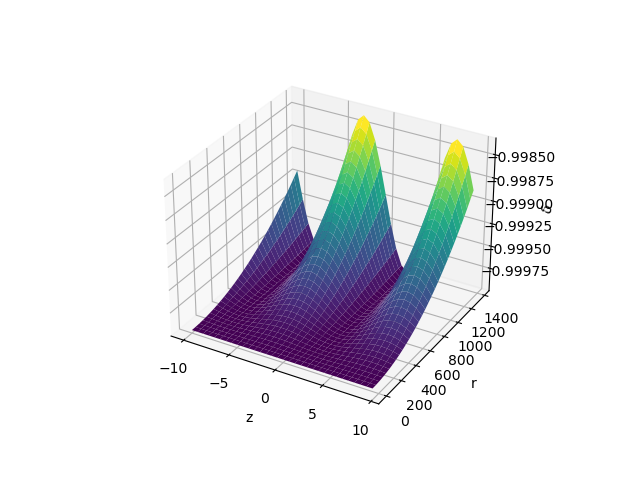

Text(0.5, 0, '$\\delta$')

In [5]:
gdown = (a(t)**2)*np.array([[Box_ones, Box_zero, Box_zero],
                            [Box_zero, Box_ones, Box_zero],
                            [Box_zero, Box_zero, Z**2]])
Kdown = -(a(t)**2)*np.array([[Box_ones*Hprop(t), Box_zero,          Box_zero],
                             [Box_zero,          Box_ones*Hprop(t), Box_zero],
                             [Box_zero,          Box_zero,          (Z**2)*(Hprop(t)+dtZ/Z)]])
delta = (DIN-F)/Z
delta_r = (DIN-F_r)/Z_r

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(z_r, r, delta_r, cmap='viridis')
ax.set_xlabel('z')
ax.set_ylabel('r')
ax.set_zlabel(r'$\delta$')

In [6]:
metric = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det(metric)
gup = RRead.inv(metric, gdet)
gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

rho = rho_flrw(t)*(1+delta)


Kmixed = np.einsum('ik...,kj... -> ij...', gup, Kdown)
K      = np.einsum('ij...,ij... -> ...', gup, Kdown)
Kup = np.einsum('ib...,ja...,ab... -> ij...', gup, gup, Kdown)

Adown  = Kdown - (K/3)*gdown
Aup    = np.einsum('ib...,ja...,ab... -> ij...', gup, gup, Adown)
A2     = np.einsum('ij...,ij... -> ...', Adown, Aup)/2

In [7]:
np.sum(abs(K/(-3*Hprop(t)-dtF/Z)-1))  #check K

2.3865354137342365e-12

In [8]:
RCW = Ricci_CoGrad_Weyl.Ricci_CoGrad_Weyl_Class(dx, periodic_boundary=False)
Christoffeludd     = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS = RCW.Ricci_TandS(gup, Christoffeludd)

In [67]:
dzZexp = RCW.FD.D3z(Z)
dzZerror = abs((dzZexp/dzZ)-1)  #check dzZ
i = 4
np.average(dzZerror), np.average(dzZerror[i:-i,i:-i,i:-i])

(0.0006473274074821142, 1.9810552480951337e-05)

In [9]:
i = 4
RicciSth = -8*B*betaP/(Z*a(t)**2)
RicciSerror = abs((RicciS/RicciSth)-1)  #check RicciS
np.nanmean(RicciSerror), np.nanmean(RicciSerror[i:-i,i:-i,i:-i])

<ipython-input-9-09bf51a1c168>:3: RuntimeWarning: invalid value encountered in true_divide
  RicciSerror = abs((RicciS/RicciSth)-1)  #check RicciS


(0.051522799103439695, 2.5323154707066118e-11)

<IPython.core.display.Javascript object>


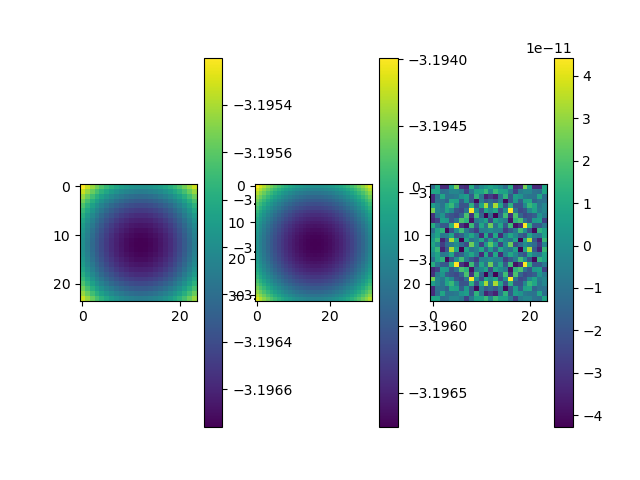

In [10]:
i = 8
plt.figure()
plt.subplot(131)
plt.imshow(RicciS[4:-4,4:-4,i])
plt.colorbar()
plt.subplot(132)
plt.imshow(RicciSth[:,:,i])
plt.colorbar()
plt.subplot(133)
plt.imshow(RicciS[4:-4,4:-4,i]/RicciSth[4:-4,4:-4,i]-1)
plt.colorbar()

In [69]:
Ham = RicciS+(2/3)*(K**2)-2*(A2)-2*Lambda-2*kappa*rho
np.average(Ham), np.average(Ham[i:-i,i:-i,i:-i]) #check Hamiltonian

(3.295527258056799e-06, 1.0765890669057521e-13)

# Check E part

In [71]:
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = 1.0
LCdown[1, 2, 0, :, :, :] = 1.0
LCdown[2, 0, 1, :, :, :] = 1.0
LCdown[2, 1, 0, :, :, :] = -1.0
LCdown[0, 2, 1, :, :, :] = -1.0
LCdown[1, 0, 2, :, :, :] = -1.0

In [72]:
Eup, E2 = RCW.Weyl_E(gdown, gup, RicciTdown, RicciS, K, Kdown, Kmixed, kappa, rho, Lambda)
Bdown, B2 = RCW.Weyl_B(LCdown, gup, gmixed, Christoffeludd, Kdown)
Edown = np.einsum('ib...,ja...,ab... -> ij...', gdown, gdown, Eup)
E = np.einsum('ij...,ij... -> ...', gdown, Eup)

In [73]:
np.average(abs(B2)), np.average(abs(Bdown))  #check B^2 and B_{ij}

(0.0, 4.818634782927453e-12)

In [74]:
np.average(abs(E)), np.average(abs(E[i:-i,i:-i,i:-i])) #check trace of E_{ij}

(4.159840989357045e-06, 8.402131266961625e-10)

In [75]:
E1 = Edown[0,0]/a(t)**2
E2 = Edown[1,1]/a(t)**2
E3 = Edown[2,2]/((Z**2)*(a(t)**2))
Ep = (E1+E2)/2
Em = (E1-E2)/(2*np.sqrt(3))

In [76]:
np.sum(abs(Em)), np.sum(abs(Em[i:-i,i:-i,i:-i]))    # check E_- = 0

(1.2379408719685936, 9.07939033599244e-05)

In [77]:
Epth = -kappa*rho_flrw(t)*delta/6
Ep_error = abs(Ep/Epth-1)    # check E_+
np.average(Ep_error), np.average(Ep_error[i:-i,i:-i,i:-i])

(4.679952191204557e-06, 9.452661900162836e-10)

# Check sigma

In [78]:
sigmadown = -Adown

In [79]:
s1 = sigmadown[0,0]/a(t)**2
s2 = sigmadown[1,1]/a(t)**2
s3 = sigmadown[2,2]/((Z**2)*(a(t)**2))
sp = (s1+s2)/2
sm = (s1-s2)/(2*np.sqrt(3))

In [80]:
tracesigma = s1+s2+s3
np.average(tracesigma), np.average(tracesigma[i:-i,i:-i,i:-i])  # check trace sigma, should be =0

(1.3986631541536634e-17, 1.3941265837231682e-17)

In [81]:
spth = -dtZ/(3*Z)
sperror = abs((sp/spth)-1)  #check sigma_+
np.average(sperror)

1.451569361434759e-16